# Comparing Reddit user engagement across fake, factual, corrective, and regular news

## Motivation

The recent focus on fake news in Western democracies within social sciences has also given rise to the related notion of astroturfing. As defined by Zhang et al. (2013):

> "Online astroturfing refers to coordinated campaigns where messages supporting a specific agenda are distributed via the Internet. These messages employ deception to create the appearance of being generated by an independent entity."

In this perspective, astroturfing can be viewed as a mechanism that enables the initial spread of a fake news item on social media. By initially associating a fake news story with artificial user activity to mimic grassroots activity, the story may gather increased attention from regular users and achieve greater user engagement over the full duration of its lifespan. 

As an example, a recent study on Twitter found that fake news are 70% more likely to be shared than factual news, and that fake news stories reach the first 1,500 users six times faster than factual news stories (Vosoughi et al., 2018).

While the spread of fake news has been studied extensively on Twitter, few studies have been conducted on Reddit. In this study, then, we will analyze whether the effect of a Reddit post's initial user engagement on total user engagement is dependent on the specific type of news story.

# ! Ref??

> Vosoughi, S., Roy, D., & Aral, S. (2018). The spread of true and false news online. Science, 359(6380), 1146-1151.

> Zhang, J., Carpenter, D., & Ko, M. (2013). Online astroturfing: A theoretical perspective.

## Data

To construct the dataset, we collect 695,147,095 Reddit posts from [Pushshift](https://pushshift.io). This constitutes every submission made between January 2016 and April 2020. We also rely on [the ClaimReview Project](https://www.claimreviewproject.com), a collective of verified journalists and fact-checkers, to obtain structured reviews of news items by scraping 151,025 ClaimReviews from [Google Fact Check Explorer](https://toolbox.google.com/factcheck/explorer) spanning from January 2015 to October 2020.

Merging these two datasets, we obtain two collections of post-review pairs: One representing the Reddit posts that link to articles that have also been reviewed by fact checkers; and another representing the posts that link directly to the corrective review articles themselves.

Since not all reviews include a quantitative truthfulness score, we include only those pairs that are numerically scored as either fake or factual. In total, we obtain 4,772 posts linking to news articles, and 17,058 linking to review articles. Among the news articles, 1,596 claims were deemed true while 3,176 were proven false. Similarly, 4,198 reviews verfied the corresponding claim as true while 12,860 disproved the claim as false.

Note that some news articles may contain multiple claims reviewed separately. In the following, we consider a news story as fake if at least one of the reviews pertaining to it identify a claim as false.

![data](../output/data_diagram_final_annotated.png)

In [1]:
import sys
sys.path.insert(0, '../model')

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from time import time

import pyro
import torch
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.contrib.autoguide import AutoDiagonalNormal

from data_proc import load_raw_data, processData, transform_data, split_and_prep_data
from post_model import post_model, post_guide
from type_model import type_model, type_guide
from story_model import story_model, story_guide
from subreddit_model import subreddit_model, subreddit_guide
from complete_model import complete_model, complete_guide
from model_utils import get_y_pred, get_type_only_y_pred, get_s_means, get_r_means, get_t_means, get_mean_y_pred
from inference import run_svi, plot_losses
from evaluation import (
    plot_predictions, plot_pp_pdf, plot_pp_cdf, plot_ppc, plot_residuals, plot_pp_hdi,
    get_samples, gather_az_inference_data, get_quantiles, MAE, MSE, R2, 
)
import torch.autograd.profiler as profiler

pyro.enable_validation(True)

First, we load in our joined raw data of the matching reddit post and claim review pairs.

In [2]:
comments, corrections, news = load_raw_data()

Next, we process and unpack data, gathering relevant features for use in our regression models.

In [3]:
data_tuple, lookup_tuple, label_tuple = processData(news + corrections, comments, minutes=60)

original_p_data, t_data, s_data, r_data, y = data_tuple
p_types, p_stories, p_subreddits = lookup_tuple
countries, authors, story_claim_titles, subreddits = label_tuple

Now, we take a log transform of post-level comments in the first hour to reason about the magnitude of the number of comments rather than the number directly (1 additional comment on a post with 5 comments may have a different effect than 1 additional comment on a post with 500 comments).

In [4]:
p_data = transform_data(original_p_data)

Finally, we split our data into test and train sets so that we can do separate evaluation on data which the model has not seen before.

In [5]:
train_data, test_data, unsplit_data = split_and_prep_data(p_data, t_data, s_data, r_data, y, p_types, p_stories, p_subreddits, train_frac=0.7)
p_data_train, y_train, p_types_train, p_stories_train, p_subreddits_train = train_data
p_data_test, y_test, p_types_test, p_stories_test, p_subreddits_test = test_data
t_data, s_data, r_data = unsplit_data

## Models

Outline which models we'll go over.

### Post level

In [6]:
pyro.clear_param_store()

In [7]:
# Define, Run Inference, Eval

In [8]:
post_svi, post_losses = run_svi(post_model, post_guide, train_data, unsplit_data, num_iters=200, lr=1e-2)

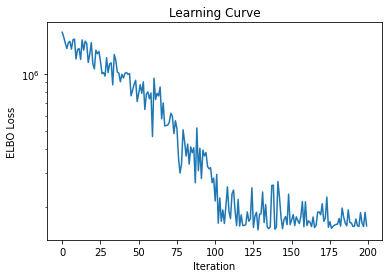

In [9]:
plot_losses(post_losses, log_scale = True, skip_first = 0)

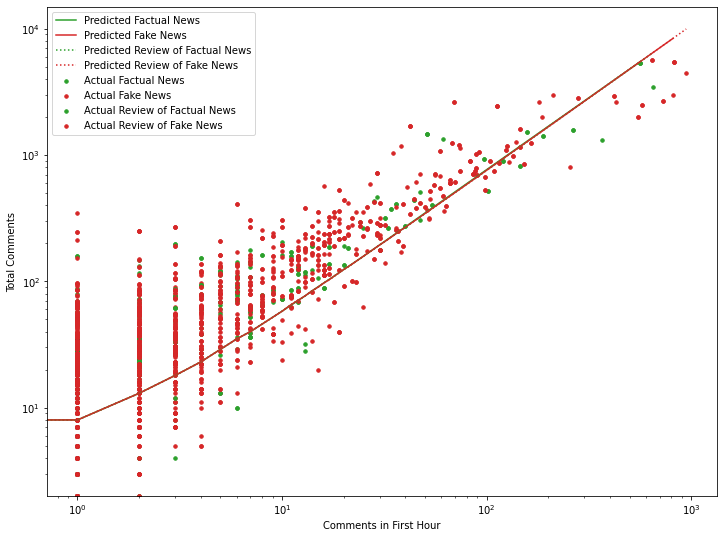

In [10]:
# Using all data (Jagged—other factors at play)
y_pred = get_y_pred(p_data, t_data, s_data, r_data, p_types, p_stories, p_subreddits)

plot_predictions(original_p_data, y, p_types, original_p_data, y_pred, p_types, indep=1, log_scale=True)

### Type level

In [11]:
pyro.clear_param_store()

In [12]:
# Define, Run Inference, Eval

In [13]:
type_svi, type_losses = run_svi(type_model, type_guide, train_data, unsplit_data, num_iters=200, lr=1e-2)

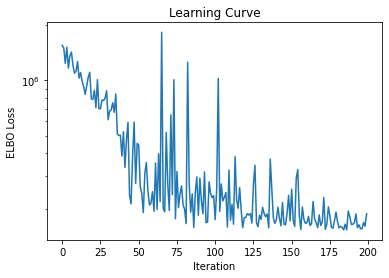

In [14]:
plot_losses(type_losses, log_scale = True, skip_first = 0)

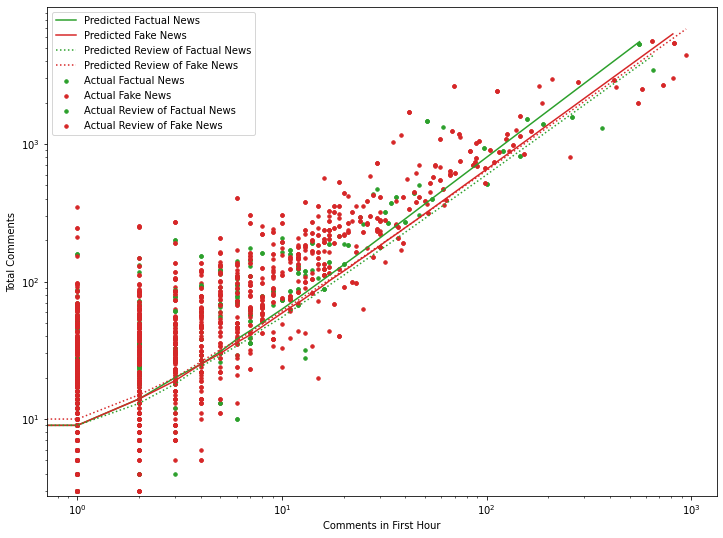

In [15]:
# Using all data (Jagged—other factors at play)
y_pred = get_y_pred(p_data, t_data, s_data, r_data, p_types, p_stories, p_subreddits)

plot_predictions(original_p_data, y, p_types, original_p_data, y_pred, p_types, indep=1, log_scale=True)

### Story level

In [16]:
pyro.clear_param_store()

In [17]:
# Define, Run Inference, Eval

In [18]:
story_svi, story_losses = run_svi(story_model, story_guide, train_data, unsplit_data, num_iters=200, lr=1e-2)

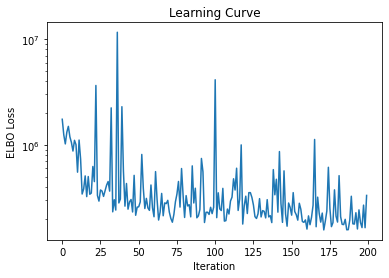

In [19]:
plot_losses(story_losses, log_scale = True, skip_first = 0)

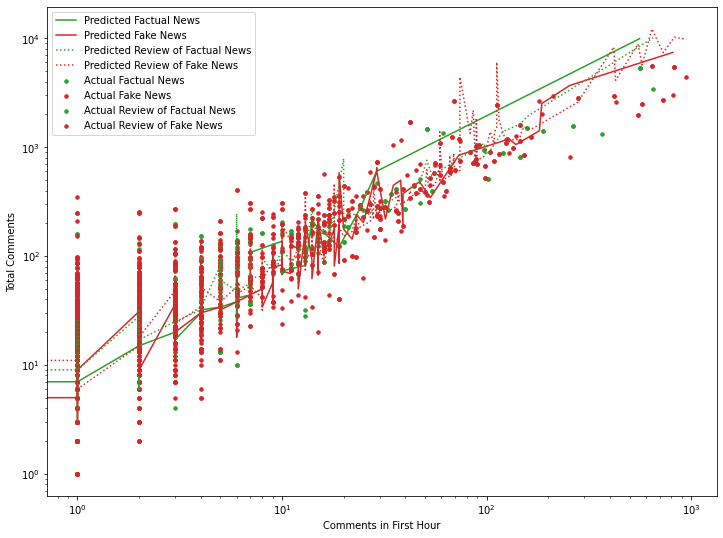

In [20]:
# Using all data (Jagged—other factors at play)
y_pred = get_y_pred(p_data, t_data, s_data, r_data, p_types, p_stories, p_subreddits)

plot_predictions(original_p_data, y, p_types, original_p_data, y_pred, p_types, indep=1, log_scale=True)

### Subreddit level

In [21]:
pyro.clear_param_store()

In [22]:
# Define, Run Inference, Eval

In [23]:
subreddit_svi, subreddit_losses = run_svi(subreddit_model, subreddit_guide, train_data, unsplit_data, num_iters=200, lr=1e-2)

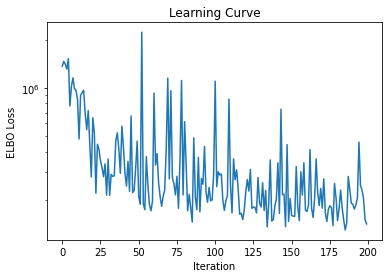

In [24]:
plot_losses(subreddit_losses, log_scale = True, skip_first = 0)

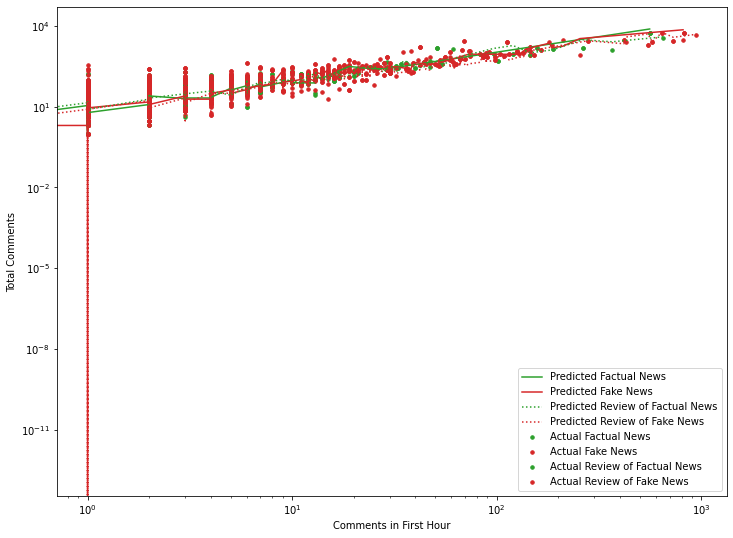

In [25]:
# Using all data (Jagged—other factors at play)
y_pred = get_y_pred(p_data, t_data, s_data, r_data, p_types, p_stories, p_subreddits)

plot_predictions(original_p_data, y, p_types, original_p_data, y_pred, p_types, indep=1, log_scale=True)

### Complete model

In [26]:
pyro.clear_param_store()

In [27]:
# Define, Run Inference, Eval

In [ ]:
complete_svi, complete_losses = run_svi(complete_model, complete_guide, train_data, unsplit_data, num_iters=200, lr=1e-2)

In [ ]:
plot_losses(complete_losses, log_scale = True, skip_first = 0)

In [ ]:
# Using all data (Jagged—other factors at play)
y_pred = get_y_pred(p_data, t_data, s_data, r_data, p_types, p_stories, p_subreddits)

plot_predictions(original_p_data, y, p_types, original_p_data, y_pred, p_types, indep=1, log_scale=True)

# Conclusion